## Regression models

Regression models are a type of supervised models that predict a continuous output variable, known as the dependent or target variable, based on one or more input variables, known as independent or predictor variables. The goal of regression is to find the relationship or mapping between the input(s) and the output, and use it to make predictions for new input data.

In this module we will start from the most common types of regression models: linear and polynomial. As we increase the complexity of the model (number of parameters), we also increase the risk of overfitting the training data. We will check for overfitting using learning curves and then show which  regularization techniques can reduce overfitting: Ridge, Lasso and ElasticNet. Finally we will explore the use for RandomForest models for regression problems.

**3.1 Load libraries and data**

In this module we will continue using the large_rivers dataset that was introduced in Module 1. Please, refer to that if your need more details explanations on the data. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Read dataframe from xlsx file
file_url = 'https://github.com/DHI/Intro_ML_course/raw/main/module_1/large_rivers_processed.csv'
df = pd.read_csv(file_url)

# If you are unable to read the file from the url, you can download it and read it locally
# file_path = 'large_rivers_processed.csv'
# df = pd.read_csv(file_path)

**3.2 Linear regression**

Let's start from a univariate problem, where we predict the Discharge given the catchmet Area. We expect a log-transformation to increase the performance of the model as it will reduce the impact of outliers, by compressing the range of the values. This will also facilitate the visualization of the results.

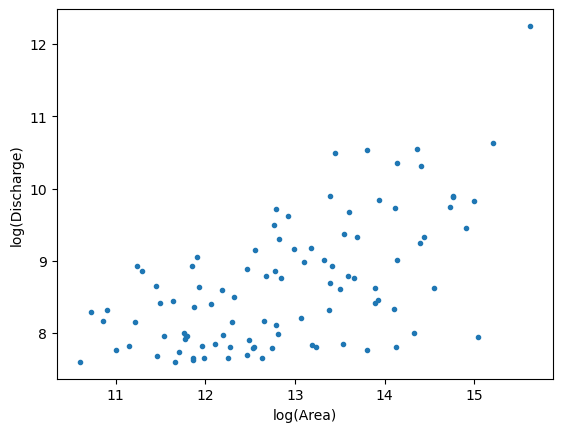

In [3]:
# Define target variable y
y = df['Discharge']

# Select input features X (only Area)
X = df[['Area']]

# Apply log transformation to both X and y
X = np.log(X)
y = np.log(y)

# Plot log transformed data
plt.scatter(X, y, marker='.')
plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.show()

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# random_state is an arbitrary number (e.g., 42) ensuring reproducibility.

# Print shape of all subsets
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (78, 1)
Shape of y_train:  (78,)
Shape of X_test:  (20, 1)
Shape of y_test:  (20,)


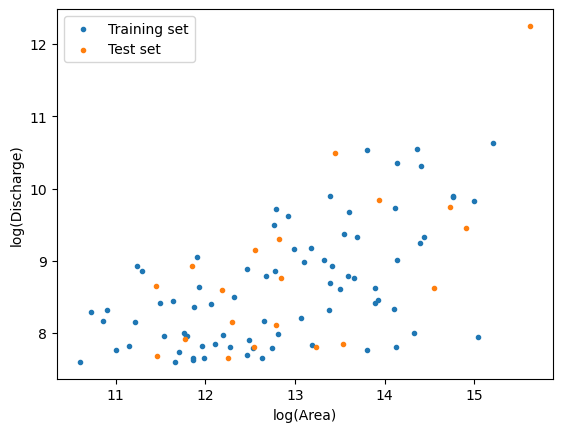

In [5]:
# Plot training and test sets in the same scatter plot
plt.scatter(X_train, y_train, marker='.', label='Training set')
plt.scatter(X_test, y_test, marker='.', label='Test set')
plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()
plt.show()

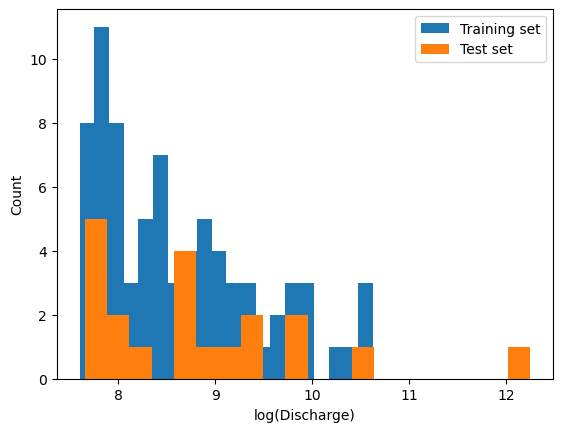

In [6]:
# Compare histograms of training and test sets
plt.hist(y_train, bins=20, label='Training set')
plt.hist(y_test, bins=20, label='Test set')
plt.xlabel('log(Discharge)')
plt.ylabel('Count')
plt.legend()
plt.show()

We start by fitting a linear model (straight line) to the data. For this univariate problem, the model coefficients will be equivalent to intercept and slope of the fitted line.

In [7]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

Slope: [0.41218567]
Intercept: 3.3346602081193097


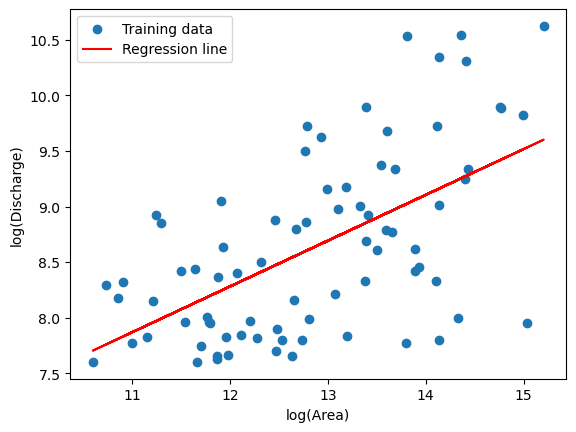

In [8]:
# Inspect and visualized the parameters of the trained model
slope = model.coef_
intercept = model.intercept_

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

# Plot scatter of x_train vs y_train and regression line
plt.scatter(X_train, y_train, label='Training data')
plt.plot(X_train, slope*X_train + intercept, color='red', label='Regression line')
plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()

Next, we need to evaluate the predictions on a independent test set. We can do this by using the predict method of the model object.

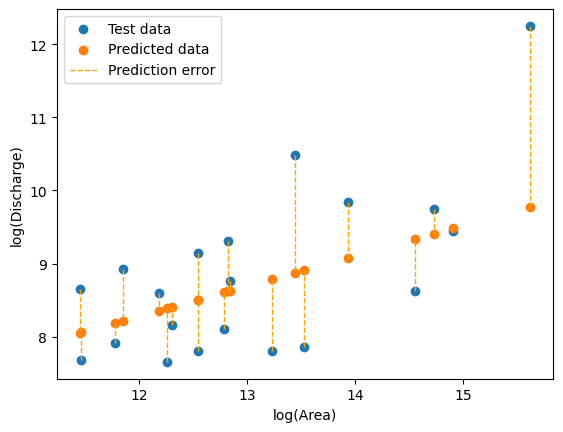

In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(X_test, y_test, label='Test data')
plt.scatter(X_test, y_pred, label='Predicted data')
# Add vertical lines connecting points to regression line
for i in range(len(X_test)):
    plt.plot([X_test.iloc[i,0], X_test.iloc[i,0]], [y_test.iloc[i],y_pred[i]], color='orange', linestyle='--', linewidth=1)

plt.plot([], [], color='orange', linestyle='--', linewidth=1, label='Prediction error') # Add entry legend

plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()
plt.show()

**Exercise 1**


Reverse the log-transform of the model predictions and compute the prediction error for the test data as RMSE in the original measuring unit (m3/s). Which other error metric can be relevant? See pre-defined metrics in sklearn: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

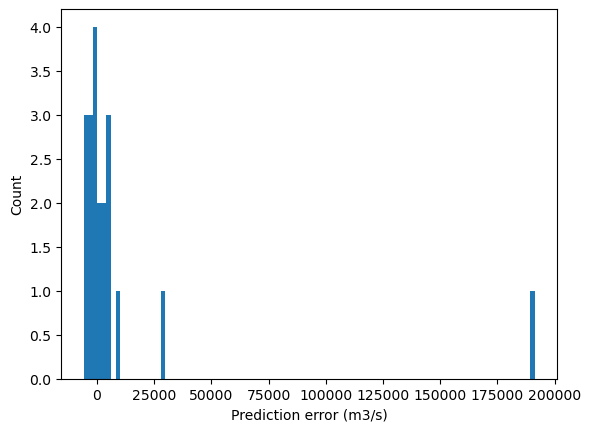

RMSE: 43445.65686347326
MAE: 13901.350247997336
MAPE: 0.6600493973007989


In [10]:
# Solution 1

# Reverse the log transformation of the predictions and test data
y_test_reverse = np.exp(y_test)
y_pred_reverse = np.exp(y_pred)

# Plot histogram of residuals
residuals = y_test_reverse - y_pred_reverse
plt.hist(residuals, bins=100)
plt.xlabel('Prediction error (m3/s)')
plt.ylabel('Count')
plt.show()

# Compute the root mean squared error of the model
mse = mean_squared_error(y_test_reverse, y_pred_reverse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Compute the error using other metrics
mae = np.mean(np.abs(y_test_reverse - y_pred_reverse))
mape = np.mean(np.abs(y_test_reverse - y_pred_reverse) / y_test_reverse)
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

**3.3 Polynomial regression**

Polynomial transformations of the input features allow to use a linear model to fit nonlinear data. All we need to do is adding powers of each feature as new features, and train a linear model on this extended set of features. The degree of the polynomial is the higher power we use in the transformation and therefore determines the number of parameters (degree of) in the model.

In [11]:
# Initialize polynomial features object
poly = PolynomialFeatures(degree=2)

# Transform X_train and X_test
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

#Compare first instance in original and transformed X_train
print('Original: ', X_train.iloc[0,:])
print('Transformed: ', X_train_poly[0,:])

Original:  Area    13.928977
Name: 49, dtype: float64
Transformed:  [  1.          13.92897673 194.01639285]


MSE:  0.6717001927970412


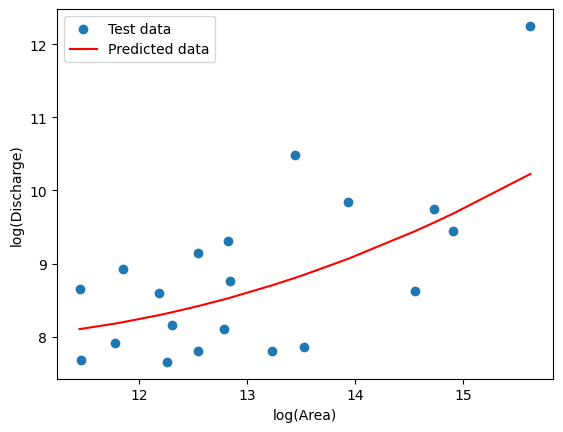

In [12]:
# Fit linear model on the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred_poly = model_poly.predict(X_test_poly)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred_poly)
print('MSE: ', mse)

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(X_test, y_test, label='Test data')

# Sort X_test and y_pred by X_test
idx = np.argsort(X_test.values.flatten())
X_test_sorted = X_test.values[idx]
y_pred_poly_sorted = y_pred_poly[idx]

plt.plot(X_test_sorted, y_pred_poly_sorted, color='red', label='Predicted data')
plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()
plt.show()


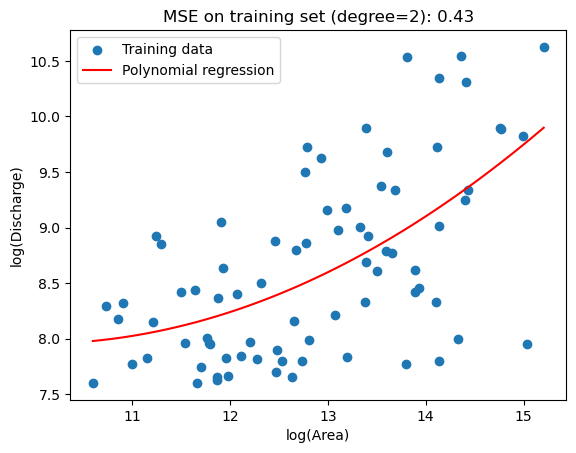

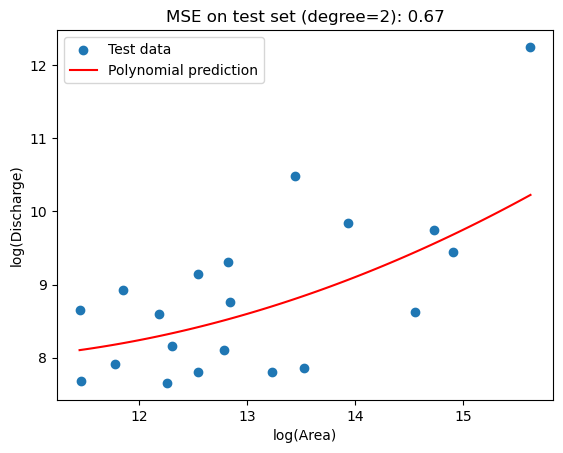

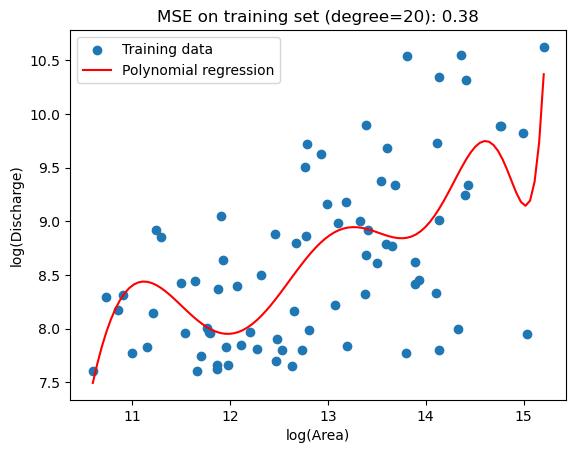

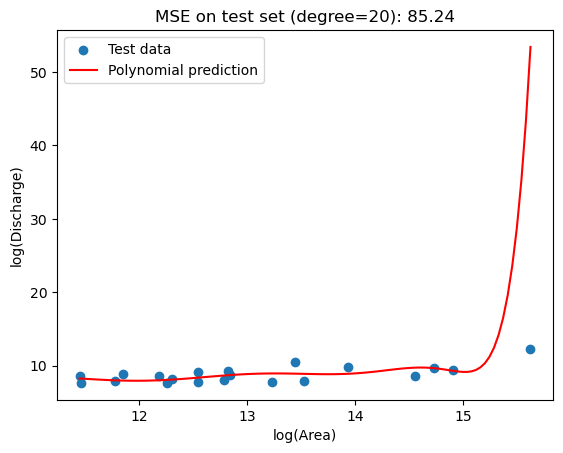

In [13]:
# Define function to plot polynomial regression with different degrees

def polynomial_regression(degree):
    # Initialize polynomial features object
    poly = PolynomialFeatures(degree=degree)

    # Transform X_train and X_test
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # Fit linear model on the polynomial features
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    # Make predictions on the training set
    y_pred_poly_train = model_poly.predict(X_train_poly)

    # Compute the mean squared error of the model
    mse_train = mean_squared_error(y_train, y_pred_poly_train)

    # Plot scatter of regression line, x_test vs y_test and y_pred
    plt.scatter(X_train, y_train, label='Training data')
    
    # Plot polynomial line
    x_range = np.linspace(X_train.min(), X_train.max(), 100)
    x_range_poly = poly.fit_transform(x_range.reshape(-1, 1))
    y_range_poly = model_poly.predict(x_range_poly)
    plt.plot(x_range, y_range_poly, color='red', label='Polynomial regression')
    
    plt.xlabel('log(Area)')
    plt.ylabel('log(Discharge)')
    # Plot MSe in title
    plt.title(f'MSE on training set (degree={degree}): {mse_train:.2f}')
    plt.legend()
    plt.show()

    # Make predictions on the test set
    y_pred_poly_test = model_poly.predict(X_test_poly)

    # Compute the mean squared error of the model
    mse_test = mean_squared_error(y_test, y_pred_poly_test)

    # Plot scatter of regression line, x_test vs y_test and y_pred
    plt.scatter(X_test, y_test, label='Test data')
    
    # Plot polynomial line
    x_range = np.linspace(X_test.min(), X_test.max(), 100)
    x_range_poly = poly.fit_transform(x_range.reshape(-1, 1))
    y_range_poly = model_poly.predict(x_range_poly)
    plt.plot(x_range, y_range_poly, color='red', label='Polynomial prediction')
    
    plt.xlabel('log(Area)')
    plt.ylabel('log(Discharge)')
    # Plot MSe in title
    plt.title(f'MSE on test set (degree={degree}): {mse_test:.2f}')
    plt.legend()
    plt.show()

    return None

# Call function for different degrees
polynomial_regression(2)
polynomial_regression(20)

**3.4 Bias/variance tradeoff**

The bias-variance tradeoff is a fundamental concept in machine learning and statistics that describes the tradeoff between two sources of error that affect the performance of a predictive model:
* **Bias** refers to the error introduced by approximating a real-world problem, which may be complex, by a simplified model. High bias means that the model is too simplistic and can't capture the underlying patterns in the data, leading to systematic errors regardless of the dataset used for training. This is also known as underfitting.

* **Variance** refers to the model's sensitivity to small changes in the training data. High variance means the model is highly flexible and fits the training data very closely, including the noise. As a result, it may perform poorly on new, unseen data because it's too tailored to the training set. This is known as overfitting.

Ideally, we would want a model with low bias and low variance, but in practice, there is a **tradeoff**. As we increase model complexity (e.g., more parameters), variance increases and bias decreases. Conversely, as we decrease model complexity, bias increases and variance decreases. The goal is to find the sweet spot where the total error is minimized, which usually involves balancing a moderate amount of bias and variance.


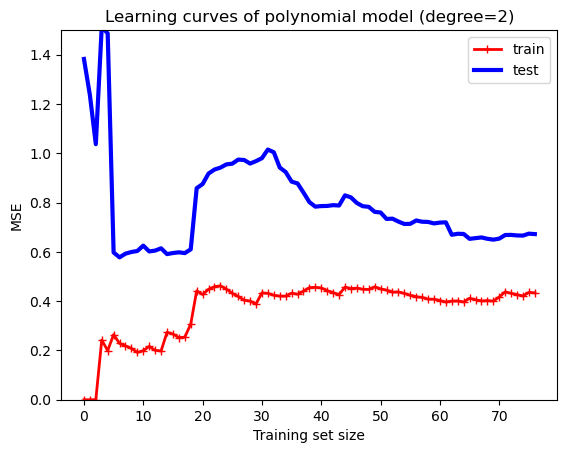

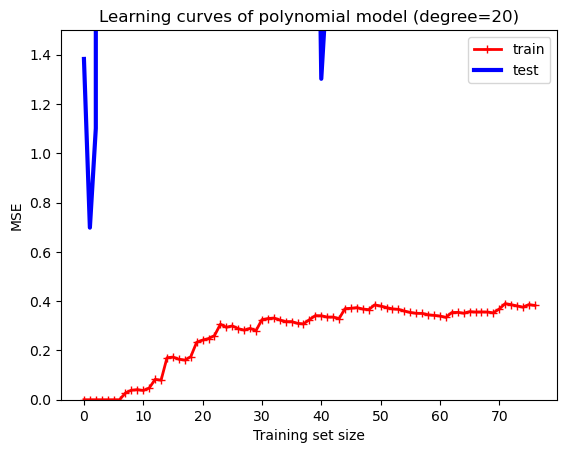

In [14]:
def plot_learning_curves(degree, X, y):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)
    train_errors, test_errors = [], []
    for m in range(1, len(X_train_poly)):
        model.fit(X_train_poly[:m], y_train[:m])
        y_train_predict = model.predict(X_train_poly[:m])
        y_test_predict = model.predict(X_test_poly)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(test_errors, "b-", linewidth=3, label="test")
    plt.ylim(0,1.5)
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('MSE')
    plt.title(f'Learning curves of polynomial model (degree={degree})')
    plt.show()

plot_learning_curves(2, X, y)
plot_learning_curves(20, X, y)

**Exercise 2**

Which polynomial degree offers the best tradeoff between the bias and variance?

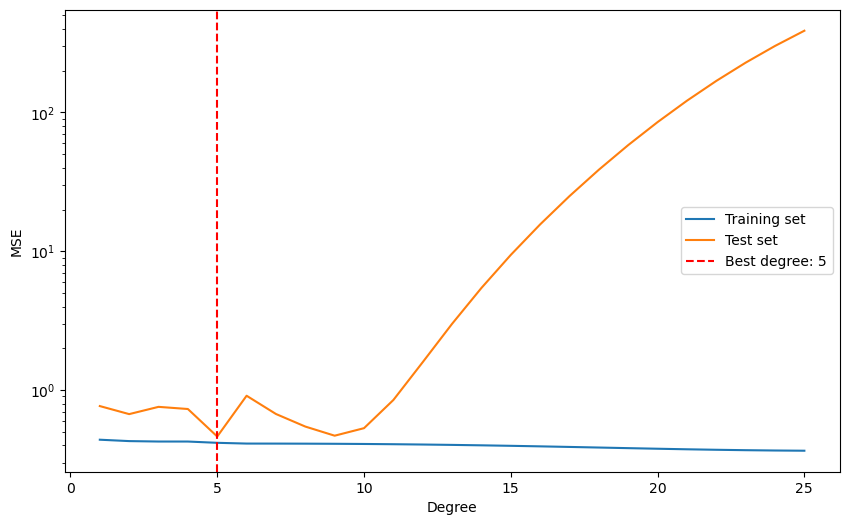

In [15]:
# Solution 2

# Define function that compute mse of training and test sets for different degrees
def polynomial_mse(degree):
    # Initialize polynomial features object
    poly = PolynomialFeatures(degree=degree)

    # Transform X_train and X_test
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # Fit linear model on the polynomial features
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    # Make predictions on the training set
    y_pred_poly_train = model_poly.predict(X_train_poly)

    # Compute the mean squared error of the model
    mse_train = mean_squared_error(y_train, y_pred_poly_train)

    # Make predictions on the test set
    y_pred_poly_test = model_poly.predict(X_test_poly)

    # Compute the mean squared error of the model
    mse_test = mean_squared_error(y_test, y_pred_poly_test)

    return mse_train, mse_test

# Compute mse of training and test sets for degrees in the range 1 to 100
degrees = range(1, 26)
mse_train = []
mse_test = []
for degree in degrees:
    mse_train_i, mse_test_i = polynomial_mse(degree)
    mse_train.append(mse_train_i)
    mse_test.append(mse_test_i)

# Find degree with lowest mse_test
best_degree = np.argmin(mse_test) + 1

# Plot mse of training and test sets for different degrees on log scale
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogy(degrees, mse_train, label='Training set')
ax.semilogy(degrees, mse_test, label='Test set')
#ax.plot(degrees, mse_train, label='Training set')
#ax.plot(degrees, mse_test, label='Test set')

# Add vertical line for degree with lowest mse_test
ax.axvline(x=best_degree, color='r', linestyle='--', label=f'Best degree: {best_degree}')

ax.set_xlabel('Degree')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

**3.5 Regularized linear models**

As shown with decision trees, a good way to reduce overfitting is to constrain the model: the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For polynomial models, the degrees of freedom can be limited by reducing the degree. This process is also called "regularization".

For a linear model, regularization can also be achieved by constraining the weights of the model. In the following we will look at three different regularization techiques that constrain the model weights: Ridge, Lasso and Elastic Net.

Before applying these regularization techniques it is generally recommended to normalize the data, otherwise some features would be unfairly penalized based on the scale of their values.

In [16]:
# Apply min/max normalization to X_train and X_test 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaling parameters to X_test
X_test_scaled = scaler.transform(X_test)

**Ridge regression** (L2 regulatization)
* Cost: mse + aplha * the sum of the squared model weights
* Tends to shrink the coefficients towards zero but does not set any of them exactly to zero.
* Useful when there are many features, all of which contribute to the prediction.

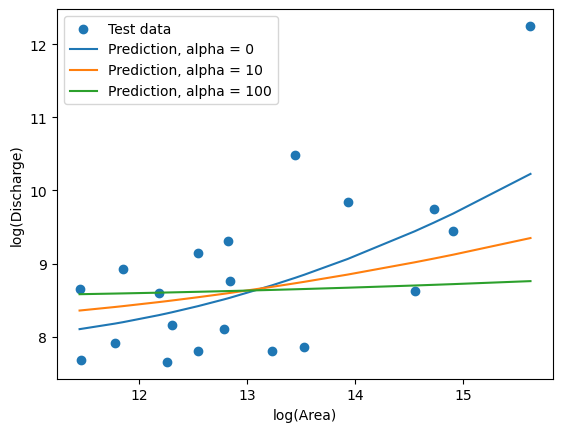

In [17]:
# Apply ridge regression to polynomial regression of degree 20 with different alpha value equal to 1 and plot regression line
from sklearn.linear_model import Ridge

# Initialize polynomial features object
poly = PolynomialFeatures(degree=2)

# Transform X_train and X_test
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

fig, ax = plt.subplots()

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(X_test, y_test, label='Test data')

def plot_ridge_regression(alpha):
    # Fit linear model on the polynomial features
    model_poly = Ridge(alpha=alpha, solver="cholesky")
    model_poly.fit(X_train_poly, y_train)

    # Make predictions on the test set
    y_pred_poly = model_poly.predict(X_test_poly)

    # Sort X_test and y_pred by X_test
    idx = np.argsort(X_test.values.flatten())
    X_test_sorted = X_test.values[idx]
    y_pred_poly_sorted = y_pred_poly[idx]

    plt.plot(X_test_sorted, y_pred_poly_sorted, label='Prediction, alpha = {}'.format(alpha))
  

plot_ridge_regression(0)
plot_ridge_regression(10)
plot_ridge_regression(100)

plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()
plt.show()

**Lasso regression** (L1 regulatization)
* Cost: a mix of the cost functions of Ridge and Lasso
* Tends to shrink some coefficients exactly to zero, effectively performing feature selection
* Useful when there are many features but only a few are expected to contribute to the response variable.

c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e+01, tolerance: 5.195e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

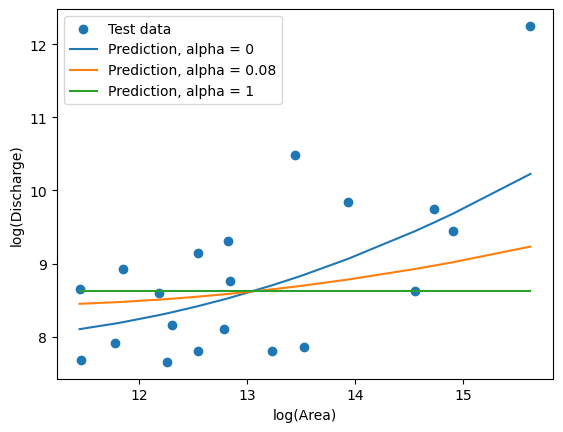

In [18]:
# Apply Lasso regression to polynomial regression of degree 20 with different alpha value equal to 1 and plot regression line
from sklearn.linear_model import Lasso

# Initialize polynomial features object
poly = PolynomialFeatures(degree=2)

# Transform X_train and X_test
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

fig, ax = plt.subplots()

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(X_test, y_test, label='Test data')

def plot_lasso_regression(alpha):
    # Fit linear model on the polynomial features
    model_poly = Lasso(alpha=alpha)
    model_poly.fit(X_train_poly, y_train)

    # Make predictions on the test set
    y_pred_poly = model_poly.predict(X_test_poly)

    # Sort X_test and y_pred by X_test
    idx = np.argsort(X_test.values.flatten())
    X_test_sorted = X_test.values[idx]
    y_pred_poly_sorted = y_pred_poly[idx]

    plt.plot(X_test_sorted, y_pred_poly_sorted, label='Prediction, alpha = {}'.format(alpha))

plot_lasso_regression(0)
plot_lasso_regression(0.08)
plot_lasso_regression(1)

plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()
plt.show()

**Elastic Net regression**
* Cost: mix of cost functions from Ridge and Lasso
* Can perform feature selection like Lasso while still retaining Ridge's benefits of coefficient shrinkage

c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e+01, tolerance: 5.195e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

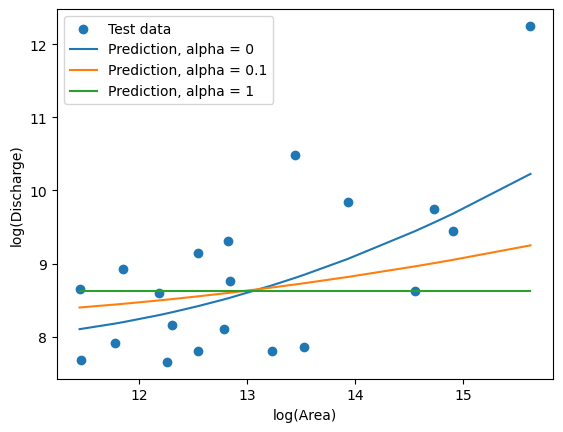

In [19]:
# Apply ElasticNet regression to polynomial regression of degree 20 with different alpha value equal to 1 and plot regression line
from sklearn.linear_model import ElasticNet

# Initialize polynomial features object
poly = PolynomialFeatures(degree=2)

# Transform X_train and X_test
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

fig, ax = plt.subplots()

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(X_test, y_test, label='Test data')

def plot_elasticnet_regression(alpha):
    # Fit linear model on the polynomial features
    model_poly = ElasticNet(alpha=alpha, l1_ratio=0.5)
    model_poly.fit(X_train_poly, y_train)

    # Make predictions on the test set
    y_pred_poly = model_poly.predict(X_test_poly)

    # Sort X_test and y_pred by X_test
    idx = np.argsort(X_test.values.flatten())
    X_test_sorted = X_test.values[idx]
    y_pred_poly_sorted = y_pred_poly[idx]

    plt.plot(X_test_sorted, y_pred_poly_sorted, label='Prediction, alpha = {}'.format(alpha))

plot_elasticnet_regression(0)
plot_elasticnet_regression(0.1)
plot_elasticnet_regression(1)

plt.xlabel('log(Area)')
plt.ylabel('log(Discharge)')
plt.legend()
plt.show()


**Exercise 3**

Can the polynomial regression of degree 20 outperform the best model found in Exercise 2 with the help of regularization?

In [20]:
# Solution 3

# Apply min/max normalization to X_train and X_test 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaling parameters to X_test
X_test_scaled = scaler.transform(X_test)

# PART 1: Compute performance of polynomial model of degree 5 without regularization

# Initialize polynomial features object
poly = PolynomialFeatures(degree=5)

# Transform X_train and X_test
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

# Fit linear model on the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions on the training set
y_pred_poly_train = model_poly.predict(X_train_poly)

# Compute the mean squared error of the model
mse_train_5 = mean_squared_error(y_train, y_pred_poly_train)
print('MSE_train of polynomial with degree 5 (without regularization): ', mse_train_5)

# Make predictions on the test set
y_pred_poly_test = model_poly.predict(X_test_poly)

# Compute the mean squared error of the model
mse_test_5 = mean_squared_error(y_test, y_pred_poly_test)
print('MSE_test of polynomial with degree 5 (without regularization): ', mse_test_5)

# PART2: Find the best possible performance of a polynomial model of degree 20 with regularization

# Initialize polynomial features object
poly = PolynomialFeatures(degree=5)

# Transform X_train and X_test
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

from sklearn.linear_model import ElasticNetCV

# Initialize elastic net object
model_poly = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .9, .95, 1], n_alphas=100, cv=5)
# read more about this model here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html

# Fit elastic net
model_poly.fit(X_train_poly, y_train)

# Make predictions on the training set
y_pred_poly_train = model_poly.predict(X_train_poly)

# Compute the mean squared error of the model
mse_train_20 = mean_squared_error(y_train, y_pred_poly_train)
print('MSE_train of polynomial with degree 20 (with regularization): ', mse_train_20)

# Make predictions on the test set
y_pred_poly_test = model_poly.predict(X_test_poly)

# Compute the mean squared error of the model
mse_test_20 = mean_squared_error(y_test, y_pred_poly_test)
print('MSE_test of polynomial with degree 20 (with regularization): ', mse_test_20)

MSE_train of polynomial with degree 5 (without regularization):  0.4172566872563371
MSE_test of polynomial with degree 5 (without regularization):  0.4632429422761978
MSE_train of polynomial with degree 20 (with regularization):  0.4411810046658317
MSE_test of polynomial with degree 20 (with regularization):  0.6704502833721481


c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08622570978513266, tolerance: 0.0043083527570596
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007175755626406044, tolerance: 0.004075607517582777
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rpal\AppData\Local\mambaforge\envs\keras\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014575767565801812, tolerance: 0.0043083527570596
  model = cd_fast.enet_coordinate_descent_gram(
c:\Use

**3.6 Multivariate linear regression**

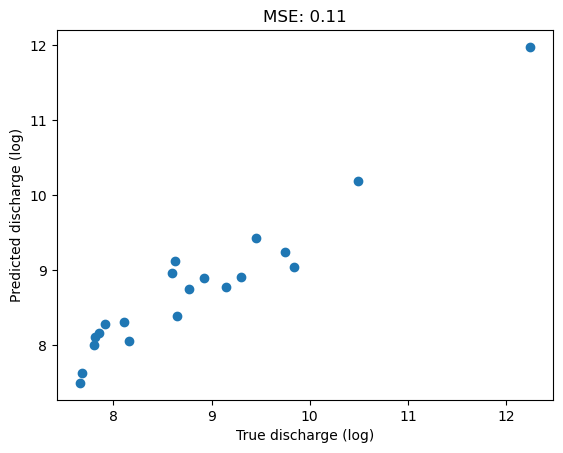

In [21]:
# Apply linear model to predict discharge from all the other features

# Define target variable y
y = df['Discharge']
y = np.log(y)

# Select input features X (all except Discharge)
X = df.drop(['Discharge', 'Name', 'Continent'], axis=1)

# Apply log transformation to Area only
X['Area'] = np.log(X['Area'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply min/max normalization to X_train and X_test
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lin_reg.predict(X_test_scaled)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('True discharge (log)')
plt.ylabel('Predicted discharge (log)')
# Add mse score in title
plt.title(f'MSE: {mse:.2f}')
plt.show()


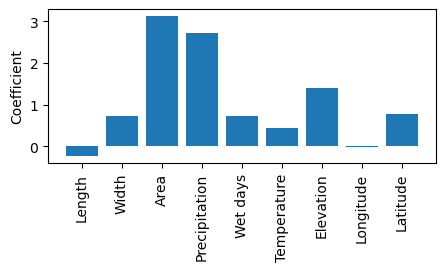

In [22]:
# Print bar chart with value of coefficients
fig, ax = plt.subplots(figsize=(5,2))
plt.bar(X.columns, lin_reg.coef_)
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.show()

**Exercise 4**

Apply the regularization techniques shown above. How do the trained coefficients of the linear model change? Can you use regularization to effectively discard some features?

MSE of lasso regression (alpha = 1):  0.2170523218206649
Optimal alpha value:  0.01
MSE of lasso regression (alpha = 0.01):  0.1707834993197791


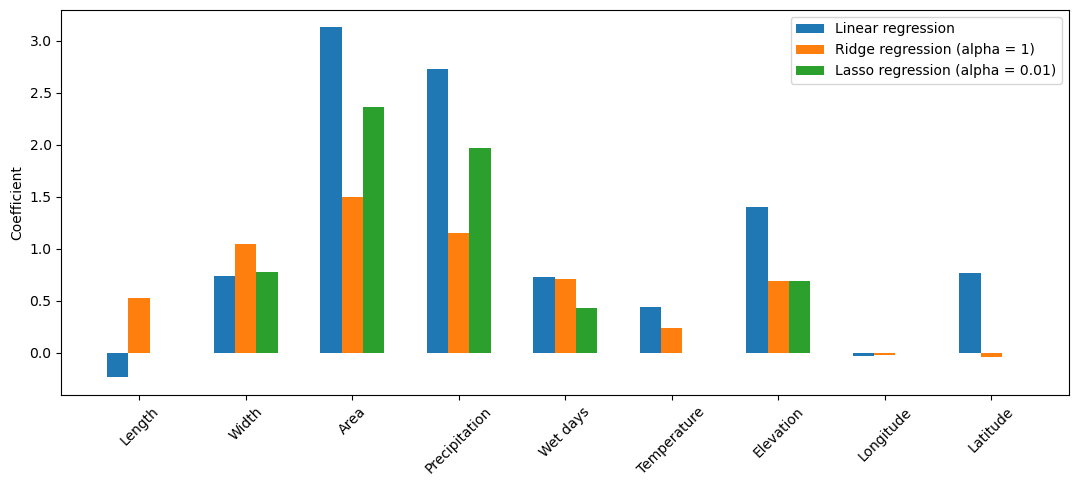

In [23]:
# Solution 4

# Apply Ridge regression and find optimal alpha value
from sklearn.linear_model import RidgeCV

# Initialize ridge regression object
ridge = RidgeCV(alphas=[ 1, 10, 100], cv=5)

# Fit ridge regression
ridge.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test_scaled)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print('MSE of lasso regression (alpha = {}): '.format(ridge.alpha_), mse)

# Apply Lasso regression and find optimal alpha value
from sklearn.linear_model import LassoCV

# Initialize lasso regression object
lasso = LassoCV(alphas=[0.01, 0.1, 1], cv=5)

# Fit lasso regression
lasso.fit(X_train_scaled, y_train)

# Print optimal alpha value
print('Optimal alpha value: ', lasso.alpha_)

# Make predictions on the test set
y_pred = lasso.predict(X_test_scaled)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print('MSE of lasso regression (alpha = {}): '.format(lasso.alpha_), mse)

# Create dataframe with x_columns and coefficients as values and leave default index
coefficients = pd.DataFrame(data={'Feature': X.columns, 'Linear regression': lin_reg.coef_, 'Ridge regression': ridge.coef_, 'Lasso regression': lasso.coef_})

# Plot bar chart with value of coefficients for linear, ridge and lasso regression
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(coefficients.index, coefficients['Linear regression'], width=0.2, label='Linear regression')
ax.bar(coefficients.index + 0.2, coefficients['Ridge regression'], width=0.2, label='Ridge regression (alpha = {})'.format(ridge.alpha_))
ax.bar(coefficients.index + 0.4, coefficients['Lasso regression'], width=0.2, label='Lasso regression (alpha = {})'.format(lasso.alpha_))
ax.set_xticks(coefficients.index + 0.2)
ax.set_xticklabels(coefficients.Feature, rotation=45)
ax.set_ylabel('Coefficient')
ax.legend()
plt.show()

**3.7 Random forest regressor** (optional)

Random Forest constructs multiple decision trees using different subsets of the training data, both in terms of instances and features. The final prediction is then obtained by aggregating the predictions from the individual trees, typically by computing the average

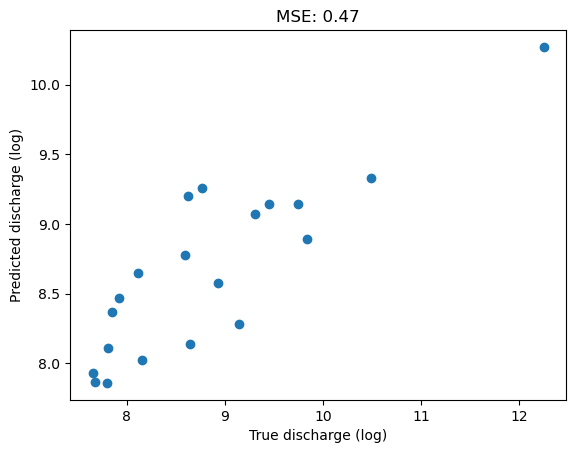

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Define target variable y
y = df['Discharge']
y = np.log(y)

# Select input features X (all except Discharge)
X = df.drop(['Discharge', 'Name', 'Continent'], axis=1)

# Apply log transformation to Area only
X['Area'] = np.log(X['Area'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_reg.predict(X_test)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)

# Plot scatter of regression line, x_test vs y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('True discharge (log)')
plt.ylabel('Predicted discharge (log)')
# Add mse score in title
plt.title(f'MSE: {mse:.2f}')
plt.show()

**Exercise 5** (optional)

Can you improve the performance of the random forest regressor by fine-tuning its hyperparameters?
* n_estimators: The number of trees in the forest.
* max_depth: The maximum depth of each tree.
* min_samples_split: The minimum number of samples required to split an internal node.
* min_samples_leaf: The minimum number of samples required to be at a leaf node.


In [25]:
# Solution 5

# Optimize hyperparameters of Random Forest Regressor using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameter grid with n_estimators, max_depth, min_samples_split and min_samples_leaf
param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [2, 5, 10, 20]}

# Initialize Random Forest Regressor
rf_reg_grid = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_reg_grid, param_grid, cv=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Make predictions on the train set
y_pred_train = grid_search.predict(X_train)
# Compute the mean squared error of the model
mse_train = mean_squared_error(y_train, y_pred_train)
print('MSE of random forest regression (train set): ', mse_train)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)

# Compute the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print('MSE of Random Forest Regressor (test set): ', mse)

# Print best parameters
print('Best parameters: ', grid_search.best_params_)

MSE of random forest regression (train set):  0.03432028596130228
MSE of Random Forest Regressor (test set):  0.48499160788963475
Best parameters:  {'max_depth': 10, 'n_estimators': 200}
